In [54]:
#import necessary packages

import pandas as pd 
import numpy as np
from numpy.linalg import norm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [4]:
K=25 
𝜆=0.1
𝜇=0.01

#number of iterations
n = 40 


In [5]:
#Define file path

input_data = '/content/drive/My Drive/Big Data Assignments/Project4/training_dataset.csv'
t_data= '/content/drive/My Drive/Big Data Assignments/Project4/test_dataset.csv'

In [6]:
#Training dataset
train_data = pd.read_csv(input_data)

In [7]:
train_data

,user_id,item_id,rating,movie_name
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)
...,...,...,...,...
94995,880,476,3,"First Wives Club, The (1996)"
94996,716,204,5,Back to the Future (1985)
94997,276,1090,1,Sliver (1993)
94998,13,225,2,101 Dalmatians (1996)


In [8]:
#Pivoted the dataframe to obtain matrix of movie vs user an the respective ratings
data_pivot = train_data.pivot(index='user_id', columns='item_id', values="rating")
print(data_pivot.shape)
data_pivot.head(20)

(943, 1665)


item_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1642,1643,1644,1645,1646,1647,1648,1649,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,NaN,2.0,5.0,5.0,5.0,5.0,5.0,3.0,4.0,NaN,4.0,1.0,4.0,4.0,3.0,4.0,3.0,2.0,4.0,1.0,3.0,3.0,5.0,4.0,2.0,1.0,NaN,2.0,3.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,3.0,NaN,NaN,4.0,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN,NaN,4.0,2.0,5.0,3.0,NaN,NaN,NaN,4.0,NaN,3.0,3.0,4.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0,3.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN,3.0,NaN,4.0,NaN,3.0,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#Obtain user list
users=list(data_pivot.index)
movies=list(data_pivot.columns)


In [10]:
#Create a matrix fromt eh pivot table
from scipy.sparse import coo_matrix

R = coo_matrix(data_pivot.values)

print ("R Shape::", R.shape)
print ("R Columns::", R.col)
print ("R Rows::",R.row)

R Shape:: (943, 1665)
R Columns:: [   0    1    2 ... 1662 1663 1664]
R Rows:: [  0   0   0 ... 942 942 942]


In [11]:
#initialize Factor matrix shape
M,N=R.shape


# using random values of P and Q 0,�5/�

P = np.random.uniform(low=0, high=np.sqrt(5/K), size=(M,K))
Q = np.random.uniform(low=0, high=np.sqrt(5/K), size=(K,N)) 

In [12]:
P.shape
Q.shape

(25, 1665)

In [13]:
#Computing Total Mean Squared Error
#--------------------------------
from numpy.linalg import norm

def error(R,P,Q,lamda=𝜆):
    ratings = R.data
    rows = R.row
    cols = R.col
    e = 0 
    for ui in range(len(ratings)):
        rui=ratings[ui]
        u = rows[ui]
        i = cols[ui]
        if rui>0:
            e= e + pow(rui-np.dot(P[u,:],Q[:,i].T),2)+\
                lamda*(pow(norm(P[u,:]),2)+pow(norm(Q[:,i]),2))
    return e

In [14]:
#Intitial Error in the data

error(R,P,Q,𝜆)


655794.401324866

In [15]:
#intial RMSE
rmse = np.sqrt(error(R,P,Q,𝜆)/len(R.data))


In [16]:
rmse

0.6462802540807366

In [75]:
#Define the function SGD, it returns P and Q matrices and also the error E
def SGD(R, K, lamda=𝜆,steps=10, gamma=𝜇):
    err=[]
    rmse_list=[]
    M,N = R.shape
    P = np.random.uniform(low=0, high=np.sqrt(5/K), size=(M,K))
    Q = np.random.uniform(low=0, high=np.sqrt(5/K), size=(K,N))
    
    rmse = np.sqrt(error(R,P,Q,lamda)/len(R.data))
    print("Initial RMSE: "+str(rmse))
    
    for step in range(steps):
        for ui in range(len(R.data)):
            rui=R.data[ui]
            u = R.row[ui]
            i = R.col[ui]
            if rui>0:
                eui=rui-np.dot(P[u,:],Q[:,i])
                P[u,:]=P[u,:]+gamma*(eui*Q[:,i]-lamda*P[u,:])
                Q[:,i]=Q[:,i]+gamma*(eui*P[u,:]-lamda*Q[:,i])
        rmse = np.sqrt(error(R,P,Q,lamda)/len(R.data))
        rmse_list.append(rmse)
        err_ite =error(R,P,Q,lamda)
        err.append(err_ite)
        print("Error in the " + str(step+1)+" iteration "+str(err_ite))
    print("Final RMSE: "+str(rmse))
    return P,Q,err,rmse_list

In [ ]:
P,Q,err,rmse=SGD(R,K,lamda=𝜆,steps=n, gamma=0.01)


In [57]:
#Prints the error list of all the iterations
print(err)

[309953.7632943047, 159281.61090073021, 155138.91419386194, 153606.9469629154, 152720.07591300918, 152089.34938389526, 151571.34316029135, 151094.60806138156, 150616.76565457843, 150113.65661368112, 149578.45728867085, 149020.85040119977, 148460.32687139083, 147915.26359587905, 147395.46195143065, 146902.1047054437, 146431.7885826495, 145980.14778110557, 145543.64682246966, 145120.08430528428, 144708.52093320835, 144309.00477891666, 143922.2390374789, 143549.25450255055, 143191.12632240023, 142848.76277324618, 142522.77838903313, 142213.4465898895, 141920.7137532473, 141644.2510681135, 141383.5221647409, 141137.85045695244, 140906.4770431046, 140688.6056824944, 140483.43501493597, 140290.1800049107, 140108.08513872392, 139936.43175058233, 139774.54141046564, 139621.7768114187, 139477.5411577076, 139341.27671517755, 139212.4629394564, 139090.61443037272, 138975.27885267723, 138866.03489643225, 138762.4903116197, 138664.28003038745, 138571.06438003865, 138482.52738548245]


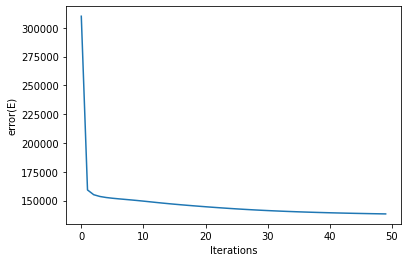

In [67]:
import matplotlib.pyplot as plt
plt.plot(err)

plt.ylabel('error(E)')
plt.xlabel('Iterations')
plt.show()

In [77]:
#Takes the P and Q matrix and predicts the ratings of the user in the test data

test_data = pd.read_csv(t_data)



orig_rating = [] # Empty list is defined for appending original ratings from the test dataset
predicted_rating = [] #  Empty List is defined for appending the predicted rating obtained from training dataset
c = 0
for i,row in test_data.iterrows(): # Iterating through each row of the test dataset and find their associate original and predicted ratings
      user = int(row['user_id']) # user details
      item = int(row['item_id'])# item details 
      orig_rating.append(int(row['rating'])) # Appends the original rating present in the test dataset
      predicted_rating.append(np.dot(P[user, :],Q[:, item])) # Appends the predicted rating obtained from the dot product of P & Q.T
       # Incrementing through each row of the test file



In [78]:
def RMSE(y_actual, y_predicted):
  rms = sqrt(mean_squared_error(y_actual, y_predicted)) # Final RMSE value is computed for both the rating lists
  return round(rms,4)
rmse_lf = RMSE(orig_rating, predicted_rating) # Pass both the ratings to RMSE function
print("RMSE obtained for latent factor model is ", rmse_lf)

RMSE obtained for latent factor model is  1.2625
